In [2]:
# Load the dataset of MNIST images and keep the first 60000
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
#X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]
X_train.shape


(60000, 784)

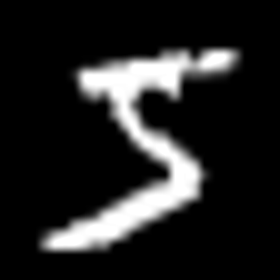

In [4]:
import PIL
from PIL import Image
# Plot the first image. Here we reshape the image from a 784 long vector to a ,→28-by-28 grid
# Since this is quite small to look at, we scale it up to 280-by-280 by ,→interpolating. This is only
#    needed for visualization
display(Image.fromarray((X_train[0,:]).astype('uint8').reshape((28,28))).resize((280, 280)))

In [5]:
import numpy as np
# This is the "average image". Try visualizing it
mu = np.mean(X_train, axis=0)
# Subtract out the mean image from each image
X_train = X_train - mu

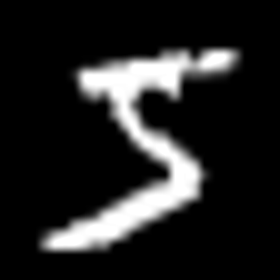

In [6]:

display(Image.fromarray((X_train[0,:]+mu).astype('uint8').reshape((28,28))).resize((280, 280)))

In [7]:
from sklearn.decomposition import PCA
# Use PCA to reduce the dimensionality from 784 to 75 (about 10%)
pca = PCA(n_components=75)
X_reduced = pca.fit_transform(X_train)
X_reduced.shape

(60000, 75)

In [15]:
# Project the 75-d data back to the 784-d space
X_recovered = pca.inverse_transform(X_reduced)
X_recovered.shape

(60000, 784)

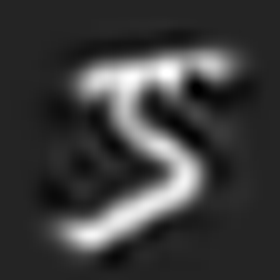

In [12]:
# Plot the first image. We first shift and rescale it to lie between 0 and 255
# Add back mean
X_rec_plt = X_recovered[0,:]+mu
# Rescale
X_rec_plt = X_rec_plt - X_rec_plt.min()
X_rec_plt = X_rec_plt*255/X_rec_plt.max()
display(Image.fromarray((X_rec_plt).astype('uint8').reshape((28,28))).resize((280, 280)))

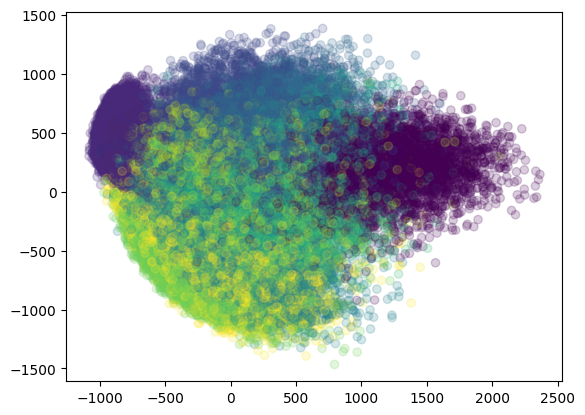

In [13]:
# Project the data down to 2d and plot a scatterplot of the images
import matplotlib.pyplot as plt
plt.scatter(X_reduced[:,0], X_reduced[:,1],c=y_train.astype('int'),alpha=0.2)

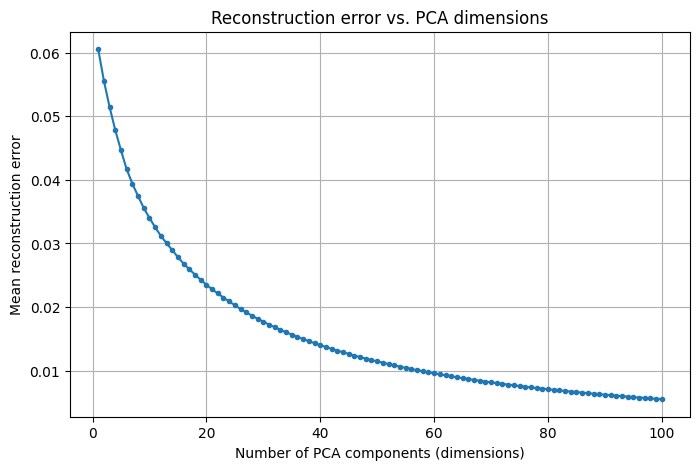

In [16]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Take a subset of MNIST (for speed)
X_subset = X_train[:5000] / 255.0  # scale to [0,1]

dims = range(1, 101)  # you can go up to 784
errors = []

for d in dims:
    pca = PCA(n_components=d)
    X_reduced = pca.fit_transform(X_subset)
    X_reconstructed = pca.inverse_transform(X_reduced)
    mse = np.mean((X_subset - X_reconstructed) ** 2)
    errors.append(mse)

plt.figure(figsize=(8,5))
plt.plot(dims, errors, '-o', markersize=3)
plt.xlabel("Number of PCA components (dimensions)")
plt.ylabel("Mean reconstruction error")
plt.title("Reconstruction error vs. PCA dimensions")
plt.grid(True)
plt.show()


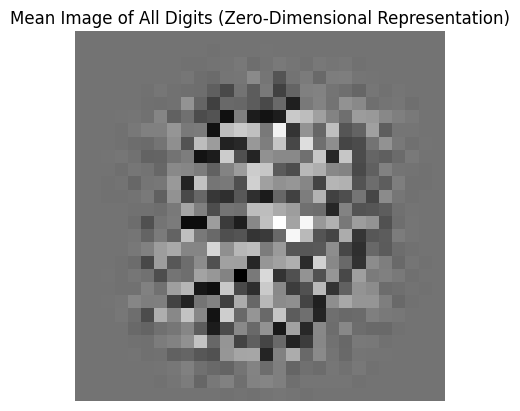

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Take a subset or whole dataset
mean_image = np.mean(X_train, axis=0)
plt.imshow(mean_image.reshape(28, 28), cmap='gray')
plt.title("Mean Image of All Digits (Zero-Dimensional Representation)")
plt.axis('off')
plt.show()


In [18]:
# Use isomap to perform nonlinear dimensionality reduction
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)
# Since this is slower, use a smaller dataset
X_isomap = embedding.fit_transform(X_train[:5000])
X_isomap.shape

(5000, 2)

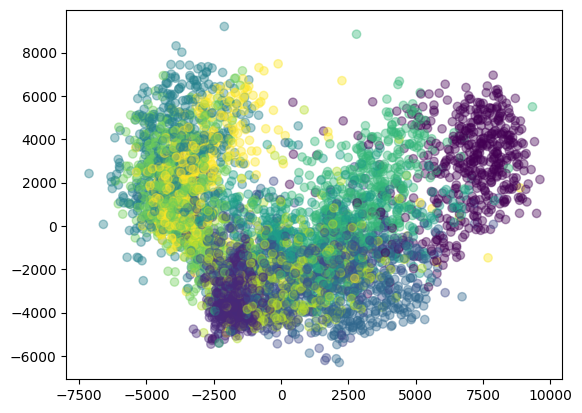

In [19]:
plt.scatter(X_isomap[:,0], X_isomap[:,1],c=y_train[:5000].astype('int'),alpha=0.4)

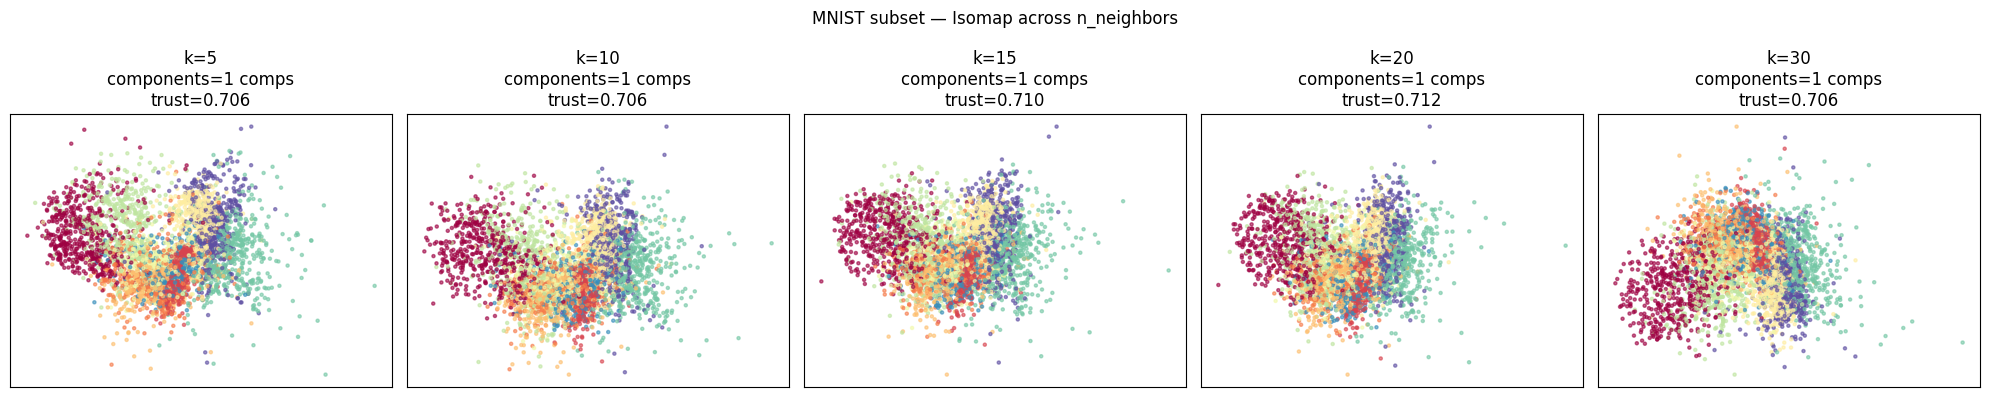

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap, trustworthiness
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import connected_components

# --- Data (reuse your MNIST arrays if already loaded) ---
# X_train: (60000, 784), y_train: (60000,)
X = X_train
y = y_train.astype(int)

# Subset + scale for speed/stability
rng = np.random.RandomState(42)
idx = rng.choice(len(X), size=5000, replace=False)
Xsub = X[idx].astype("float32") / 255.0
ysub = y[idx]
Xsub = StandardScaler().fit_transform(Xsub)

ks = [5, 10, 15, 20, 30]
embeds, tw_scores, conn = {}, {}, {}

for k in ks:
    # 1) Fit Isomap
    iso = Isomap(n_neighbors=k, n_components=2,
                 neighbors_algorithm="auto",
                 path_method="auto",
                 eigen_solver="auto")
    X_iso = iso.fit_transform(Xsub)
    embeds[k] = X_iso

    # 2) Build k-NN graph explicitly and check connectivity
    G = kneighbors_graph(Xsub, n_neighbors=k, mode="connectivity", include_self=False)
    n_comp, _ = connected_components(G)
    conn[k] = n_comp

    # 3) Trustworthiness for local structure
    tw_scores[k] = trustworthiness(Xsub, X_iso, n_neighbors=10)

# 3-panel (or multi-panel) visualization
fig, axes = plt.subplots(1, len(ks), figsize=(4*len(ks), 4))
for ax, k in zip(axes, ks):
    ax.scatter(embeds[k][:,0], embeds[k][:,1], c=ysub, s=5, alpha=0.6, cmap='Spectral')
    ax.set_title(f'k={k}\ncomponents={conn[k]} comps\ntrust={tw_scores[k]:.3f}')
    ax.set_xticks([]); ax.set_yticks([])
plt.suptitle("MNIST subset — Isomap across n_neighbors")
plt.tight_layout(); plt.show()
